# Example of XPC on SMACH data

This notebook illustrates how to use the XPC package on data simulated using SMACH and GAM models coded in R. The dataset contains true climate and non-climate parts, and the models are already trained.

### Imports

In [1]:
import os
os.chdir("..") #go to directory containing xpc package, call only once

In [2]:
from xpc.utils import data #to load datasets
from xpc.utils import models #to load models
from xpc.utils import series #to manipulate time series
from xpc.utils import plots #to plot time series

from xpc import shapley #to compute Shapley values
from xpc import ale #to draw ALE
from xpc import pdp #to draw PDP

from time import perf_counter 
import numpy as np

## Loading data and model

### Data

Load the train and test datasets used to train the model

In [3]:
path = "datasets/data_smach"
df_train = data.read_dataset("df_train", path)
df_test = data.read_dataset("df_test", path)

print("Train shape: ", df_train.shape)
print("Test shape: ", df_test.shape)

df_train.head()

Train shape:  (70128, 17)
Test shape:  (17520, 17)


,temp,wind,sun,Load,PC,HPC,Instant,Posan,JourSemaine,JourFerie,offset,DayType,Weekend,temp_liss_fort,temp_liss_faible,tempMax,tempMin
date,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,8.104904,6.811419,0.0,8719035,3664048,5054987,2,0.000114,1,1,20,30,0,10.038271,6.619628,8.991753,6.734967
2018-01-01 00:30:00+00:00,7.951111,6.752895,0.0,9615775,3953776,5661999,3,0.000171,1,1,20,30,0,9.979830,6.623622,8.991753,6.734967
2018-01-01 01:00:00+00:00,7.797317,6.694370,0.0,11355298,4087983,7267315,4,0.000228,1,1,20,30,0,9.918720,6.627144,8.991753,6.734967
2018-01-01 01:30:00+00:00,7.706135,6.611597,0.0,10073389,4200626,5872763,5,0.000285,1,1,20,30,0,9.856767,6.630381,8.991753,6.734967
2018-01-01 02:00:00+00:00,7.614952,6.528824,0.0,9227768,3911412,5316356,6,0.000342,1,1,20,30,0,9.793996,6.633334,8.991753,6.734967


Separate features from load and true climate and non-climate parts. Train data will be used as "background" and test data as $X$.

For visualization purposes, we will sometimes consider $X_{ws}$, a subset of $X$ containing only 1 day in winter and 1 in summer.

In [4]:
#background
background = df_train.drop(columns=["Load", "PC", "HPC"])
background_y = df_train.Load
background_parts = df_train[["PC","HPC"]].rename(columns={"PC":"C","HPC":"NC"})

#X
X = df_test.drop(columns=["Load", "PC", "HPC"])
y = df_test.Load
true_parts = df_test[["PC","HPC"]].rename(columns={"PC":"C","HPC":"NC"})

#2 days subsets
Nday = 48 #number of instants per day
T = list(range(Nday)) + list(range(Nday*365//2,Nday*365//2+Nday)) # winter and summer indexes
Xws, yws, partsws = X.iloc[T], y.iloc[T], true_parts.iloc[T]
print("Xws shape: ",Xws.shape)

Xws shape:  (96, 14)


We have to declare which variables are for the climate part and which are non-climate.

Also, we may describe the type for each feature. This will help computing conditional distributions.

In [5]:
col_mapping = {
    "C":["temp", "temp_liss_fort","temp_liss_faible","tempMax","tempMin","sun","wind"],
    "NC":["Instant", "JourSemaine","Weekend","Posan","JourFerie","offset","DayType"],
}


feature_types = {
    "temp":"continuous",
    "wind":"continuous",
    "sun":"continuous",
    "temp_liss_fort":"continuous",
    "temp_liss_faible":"continuous",
    "tempMax":"continuous",
    "tempMin":"continuous",
    "Posan":"cyclic",
    "Instant":"cyclic",
    "JourFerie":"categorical",
    "offset":"categorical",
    "DayType":"categorical",
    "Weekend":"categorical",
    "JourSemaine":"categorical"
}

### Model

Load the model by indicating the path to a folder which must contain:
- the .rds model
- an R script to call the model (example is provided in Rmodels)
- input and output .csv to store the data

In [6]:
#model
model_path = "models/Rmodels/1t"
features = ["temp","Instant","DayType"] #declare the features used by the model to accelerate computations
model = models.MyModel(model_path, model_class="gam", features=features) #declare the model as GAM to compute spline parts

We can look at the distribution of prediction errors from the model if we have access to the true values y

Computation time: 5.9 s
Mean Errors : -2.49 %


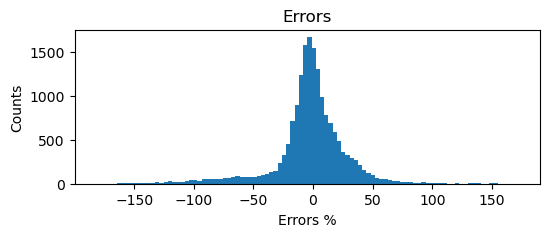

Mean Absolute errors : 19.90 %


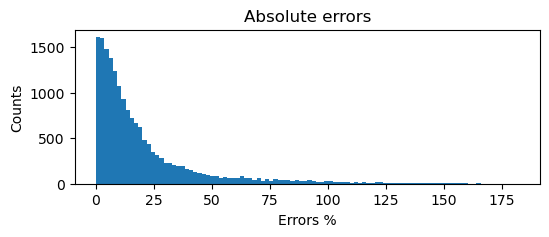

In [7]:
#X predictions
predictions, time = series.time_model(model, X)
print(f"Computation time: {time:.1f} s")

#error analysis
series.analyze_errors(predictions, y, relative=True, percents=True, title="Errors")
series.analyze_errors(predictions, y, relative=True, percents=True, absolute=True, title="Absolute errors")

## Global interpretability

### PDP

We can draw Partial Dependance Plots (PDP) 

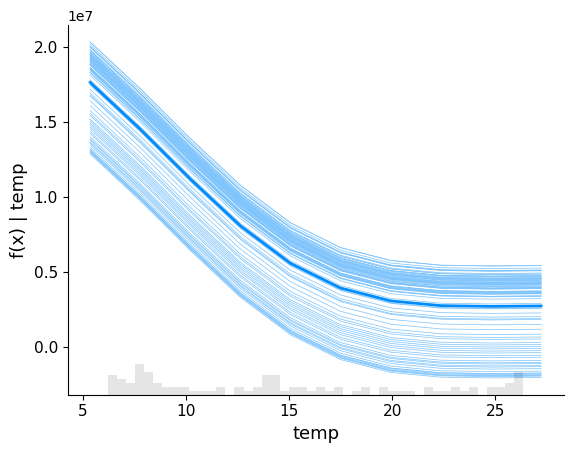

In [9]:
pdp.draw(model, Xws, "temp") #very slow if model call is slow (e.g R script). If not, you may increase npoints size (default:10)

### ALE

We can draw 1st or 2nd order Accumulated Local Effects (ALE) plots, for continous or discrete variables.

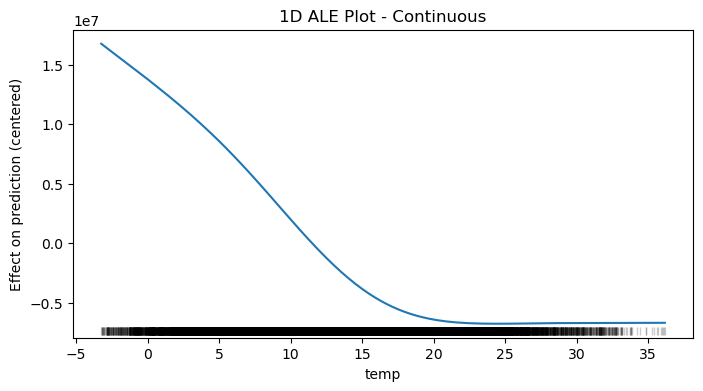

In [10]:
#first order effects
feature = "temp"
ale.draw_1d(model, X, feature)

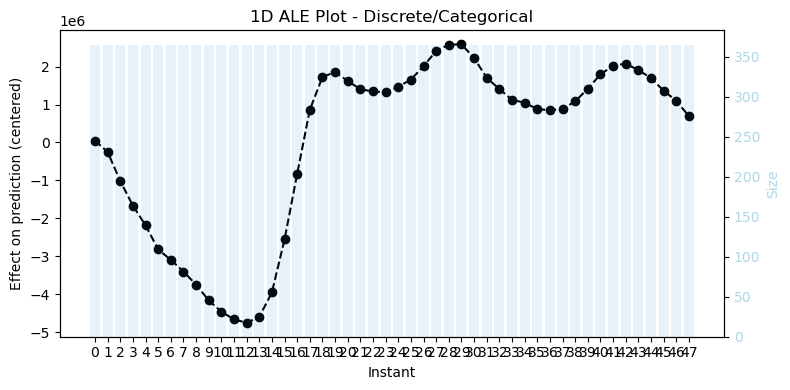

In [11]:
#categorical variables
ale.draw_1d(model, X, "Instant", feature_type="discrete")

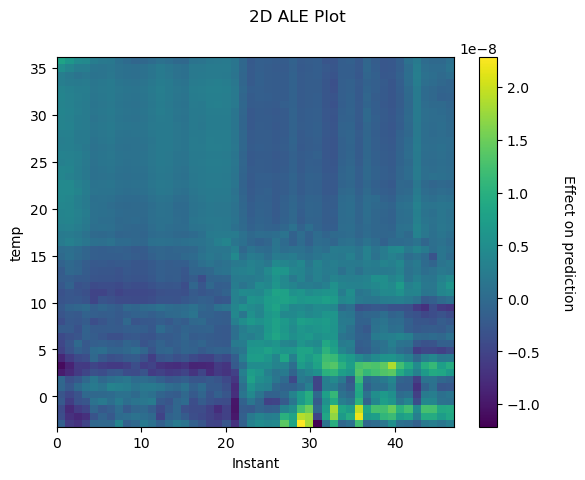

In [12]:
#second order effects
features = ["temp", "Instant"]
ale.draw_2d(model, X, features)

Other parameters include:
- include_CI: draw confidence intervals
- grid_size: size of grid for discretization

## Shapley

To compute Shapley values, which must choose an algorithm from:
- Permutation SHAP
- Kernel SHAP
- Monte Carlo
- Exact (slow unless model is a monovariate GAM)

Details on each can be found in the documentation. 

In [13]:
algo = "monte_carlo"
params = {"n_coalitions":10, "n_approx":1, "do_double":True}

explainer = shapley.explainers.Shapley(model, algo=algo, col_mapping=col_mapping, **params)

In the previous call using Monte Carlo, the chosen parameters are:
- n_coalitions: number of sampled coalitions
- n_approx: number of background samples for each coalition
- do_double: sample different background for $v_x(S)$ and $v_x(S \cup \{j\}$

Then, you must fit the explainer on the background values and chosen features.

In [14]:
explainer.fit(background)

background_data = explainer.background_dict
print("Expectation: ",np.round(background_data["background_expectation"],1))
print("Mean parts %:",np.round(background_data["background_spline_mean_percents"],2), "(climate / non-climate)")

Expectation:  10151377.2
Mean parts %: [0.42 0.58] (climate / non-climate)


We can see that the explainer has computed background information using the spline values. In particular, the $\textrm{background_expectation}$ will be used as the offset for Shapley values. It will be decomposed into a climate and non-climate part using $\textrm{background_spline_mean_percents}$. This is enabled by the monovariate GAM model. For other models, equal contributions will be discounted from the offset.

Note that you may give more information to the model such as the true parts of the background. This will allow a more precise decomposition of the expectation.

In [15]:
background_dict = {"background_y":background_y, "background_contribs":background_parts}
explainer.fit(background, background_dict)
print("Mean parts %:",np.round(explainer.background_dict["background_true_mean_percents"],2), "(climate / non-climate)")

Mean parts %: [0.29 0.71] (climate / non-climate)


Now, you can call the explainer on the values to explain, and plot the estimated parts.

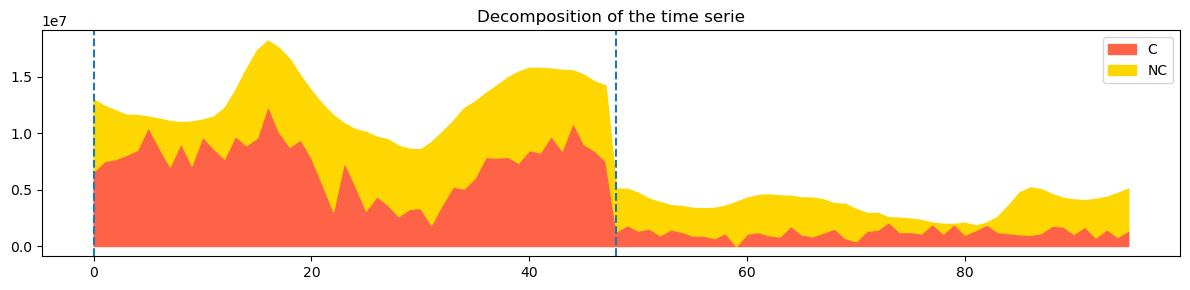

In [16]:
parts = explainer(Xws)
plots.show_sum(parts, color_mapping={"C":"tomato","NC":"gold"})

We can compare with the true contributions from SMACH, and check the mean errors.

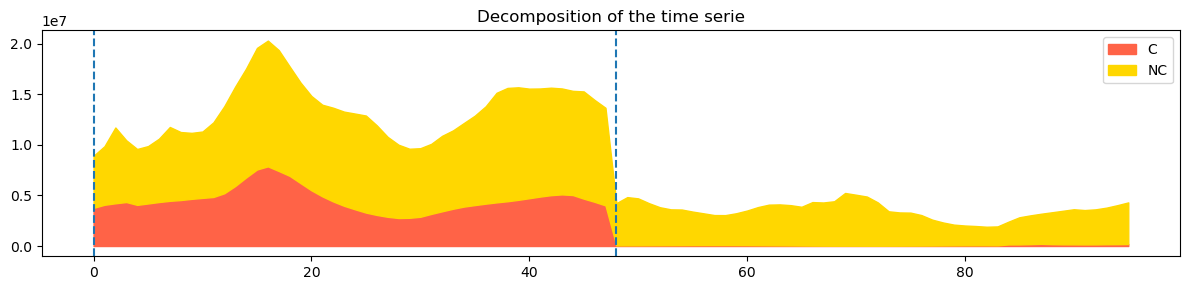

Mean absolute error of climate part:  1032.17  %


In [17]:
plots.show_sum(partsws, color_mapping={"C":"tomato","NC":"gold"})
err = series.score(parts["C"], partsws["C"], relative=True, percents=True, absolute=True)
print("Mean absolute error of climate part: ",round(err,2)," %")

The estimation is not great. So, we decide to increase the number of coalitions and background samples (this will also increase the computation time).

We call the whole pipeline directly, and give true information relative to X for more detailed errors.


Total computations done in 0.79 min
efficiency error: 3.03 %
SMACH error: 20.67 %
GAM error: 8.83 %
Exact shap error: 1.98 %


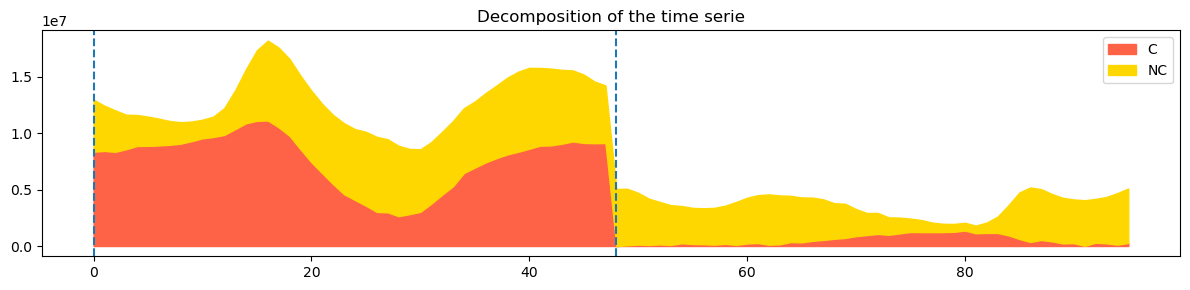

In [18]:
algo = "monte_carlo"
params = {"n_coalitions":100, "n_approx":10}

background_dict = {"background_y":background_y, "background_contribs":background_parts}
X_dict = {"y":yws, "true_contribs":partsws}

parts, errors_dict, explainer = shapley.analysis.pipeline(
    model, background, Xws, algo, col_mapping=col_mapping,
    background_dict=background_dict, X_dict=X_dict,
    do_exact=True,
    return_all = True,
    **params)

explainer.print_shap_errors()
plots.show_sum(parts, color_mapping={"C":"tomato","NC":"gold"})

This looks much better. The described errors correspond to:
- efficiency error : between the sum of estimated parts and model prediction
- SMACH error : between the estimated climate part and the SMACH climate part (only for SMACH)
- GAM error: between the estimated climate part and the GAM climate part (only for GAMs)
- Exact shap error: between the estimated climate part and the exact SHAP climate part (only for the monovariate GAM)

We could also decide to use the spline contributions rather than the Shapley values to obtain the parts.


Total computations done in 0.18 min
efficiency error: 59.18 %
SMACH error: 6.5 %
GAM error: 8.77 %


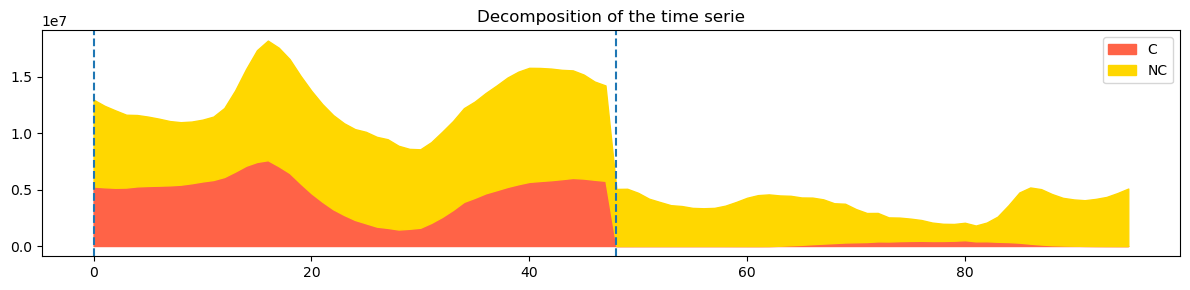

In [13]:
algo = "splines"

background_dict = {"background_y":background_y, "background_contribs":background_parts}
X_dict = {"y":yws, "true_contribs":partsws}

parts, errors_dict, explainer = shapley.analysis.pipeline(
    model, background, Xws, algo, col_mapping=col_mapping,
    background_dict=background_dict, X_dict=X_dict, return_all = True)

explainer.print_shap_errors()
plots.show_sum(parts, color_mapping={"C":"tomato","NC":"gold"})